In [85]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Optimal Execution of Portifolio Transactions

This notebook contains a simulation inspired on the paper from Robert Almgren and Neil Chriss of "Optimal Execution of Portifolio Transactions". Please refer to the paper for the demonstration of certain formulas used in this notebook.

## Strategy and price dynamics

### Permanent impact

Here we take the following discretized model for price dynamics with $N$ steps:

$$
S_{k} = S_{k-1} + \sigma \tau^{\frac{1}{2}} \xi_{k} - \tau g\left(\frac{n_{k}}{\tau}\right)
$$

We take $\sigma$ to be the volatility of the asset, $\tau = \frac{N}{T}$, $(\xi_{i})_{i\in \{1,\dots,N\}}$ a sequence of i.i.d random variables of mean zero and unit variance, $n_{k}$ is the number of assets that were sold at step $k$. For our simulations we will stick to a normal distribution. The term $g$ contains the permanent impact of our strategy on the price of the asset.

As in the paper, we take a linear function for $g$, $g(v) = \gamma v$, hence:

$$
S_{k} = S_{0} + \sigma \sum_{j=1}^{k}\tau^{\frac{1}{2}}\xi_{j} - \gamma(X - x_{k})
$$

Where $X$ is the initial portifolio size and $x_{k}$ is the amount of units of the asset we still hold.



### Temporary impact

We will also take the temporary market impact linearly, hence we will assume that every time we trade there is an effective price that we are able to get:

$$
\tilde{S}_{k} = S_{k-1} - h(n_{k}) = S_{k-1} - \epsilon \text{ sgn}(n_{k}) - \frac{\eta}{\tau}n_{k}
$$



### Total cost of trading

Our total cost of trading then becomes:

$$
C = XS_{0} - \sum_{k = 1}^{N}n_{k}\tilde{S}_{k} = - \sum_{k = 1}^{N}\left(\sigma \tau^{\frac{1}{2}}\xi_{k} - \tau g\left( \frac{n_{k}}{\tau} \right) \right) x_{k} + \sum_{k=1}^{N}n_{k}h\left(\frac{n_{k}}{\tau} \right)
$$

Replacing the linear impact:

$$
C = - \sum_{k = 1}^{N}\left(\sigma \tau^{\frac{1}{2}}\xi_{k} - \gamma n_{k} \right) x_{k} + \sum_{k=1}^{N}n_{k} \left(\epsilon\text{ sgn}(n_{k}) + \frac{\eta}{\tau}n_{k}\right)
$$

Assuming all $n_{k}$ have the same positive sign:

$$
C = - \sum_{k = 1}^{N}\left(\sigma \tau^{\frac{1}{2}}\xi_{k} - \gamma n_{k} \right) x_{k} + \epsilon X + \frac{\eta}{\tau} \sum_{k=1}^{N}n_{k}^{2} 
$$

$$
C = - \sum_{k = 1}^{N}\sigma \tau^{\frac{1}{2}}\xi_{k}x_{k} + \sum_{k = 1}^{N}\gamma n_{k} x_{k} + \epsilon X + \frac{\eta}{\tau} \sum_{k=1}^{N}n_{k}^{2} 
$$

$$
C = - \sum_{k = 1}^{N}\sigma \tau^{\frac{1}{2}}\xi_{k}x_{k} + \frac{1}{2}\gamma X^{2} - \frac{1}{2} \gamma \sum_{k = 1}^{N}n_{k}^{2} + \epsilon X + \frac{\eta}{\tau} \sum_{k=1}^{N}n_{k}^{2} 
$$

$$
C = - \sum_{k = 1}^{N}\sigma \tau^{\frac{1}{2}}\xi_{k}x_{k} + \frac{1}{2}\gamma X^{2} + \epsilon X - \left(\frac{\eta}{\tau} - \frac{1}{2} \gamma\right) \sum_{k = 1}^{N}n_{k}^{2}  
$$

Which should yield in expected value:

$$
\mathbb{E}[C] =  \frac{1}{2}\gamma X^{2} + \epsilon X - \left(\frac{\eta}{\tau} - \frac{1}{2} \gamma \right) \sum_{k = 1}^{N}n_{k}^{2}
$$

## Minimum impact

Here we model the minimum impact strategy. As it is shown in the paper, it is the one of lowest expected value. For this strategy we have the following expected value:

$$
E = \frac{1}{2} \gamma X^{2} + \epsilon X + \left(\eta - \frac{1}{2}\gamma \tau\right)\frac{X^{2}}{T}
$$

In this section we will simulate such strategy and verify if it follows indeed the theoretical prediction.

In [136]:
def update_price(
        S: float, 
        sigma: float, 
        tau: float, 
        gamma: float,
        n: float
        ) -> float:
    '''
    Takes as input the previous price and returns the new one
    '''
    return S + sigma*np.sqrt(tau)*np.random.normal(0,1) - gamma*n
    

def linear_effective_price(
        S: float, 
        n: float, 
        eps: float, 
        tau: float,
        eta : float
        ) -> float:
    '''
    Gets the effective price of a trade in the linear setting
    '''
    return S - eps*np.abs(n) - (eta/tau)*n

def get_linear_position(
        X: float, 
        N: int
        ) -> float:
    '''
    Gets the position at each step for linear setting
    '''
    return X/N

def update_portifolio(
        X: float, 
        n: float
        ) -> float:
    '''
    Updates the amount of shares we hold
    '''
    return X - n

def step_simulation(
        X: float,
        gamma: float,
        eps: float,
        eta: float,
        sigma: float, 
        T: float, 
        N: int,
        portifolio_size: np.array):
    '''
    Executes the simulation step by step
    '''
    
    ...

def complete_simulation(X: float,
        gamma: float,
        eps: float,
        eta: float,
        sigma: float, 
        T: float, 
        N: int,
        portifolio_size: np.array
        ) -> float:
    
    ## Variable cost
    # Generates all gaussians
    tau = T/N
    ran_var = sigma*np.sqrt(tau)*np.random.normal(0, 1, N)

    cost_var = np.dot(portifolio_size, ran_var)

    ## Getting term of nks

    ns = np.ones(N)
    ns[1:] = portifolio_size[:-1] - portifolio_size[1:]
    ns[0] = 1-portifolio_size[0]

    ns_term = (eta - (gamma*tau/2))*np.sum(ns**2)

    return (1/2)*gamma*X**2 + eps*X + ns_term  - cost_var

def complete_simulation_equally( 
        X: float,
        gamma: float,
        eps: float,
        eta: float,
        sigma: float, 
        T: float, 
        N: int
        ) -> float:
    '''
    Simulates the strategy by running all steps at once return the cost of the strategy
    '''
    
    ## Variable cost
    # Generates all gaussians
    tau = T/N
    ran_var = sigma*np.sqrt(tau)*np.random.normal(0, 1, N)

    # Equally spaced portifolio
    xs = X * (1 - np.arange(1,N+1) / N)

    cost_var = np.dot(xs, ran_var)

    return (1/2)*gamma*X**2 + eps*X + (eta - (gamma*tau/2))*(X**2/T) - cost_var

def expected_linear_trading_cost(
        X: float, 
        gamma: float, 
        eps: float, 
        eta: float, 
        T: float, 
        N: int
        ) -> float:
    '''
    Computes the expected value of the linear strategy
    '''
    tau = T/N

    return (1/2)*gamma*X**2 + eps*X + (eta - (gamma*tau/2))*(X**2/T)

In [137]:
# Parameters taken from the paper
S0 = 50
X = 1e6
T = 5
N = 5
sigma = 0.95
eps = 0.0625
gamma = 2.5 * 1e-7
eta = 2.5 * 1e-6

tau = T/N

# Generating gaussians
xi = np.random.normal(0,1,N)
ns = np.ones(N) / N

### Studying the shape of the cost of trading under linear assumptions (lower cost configuration)

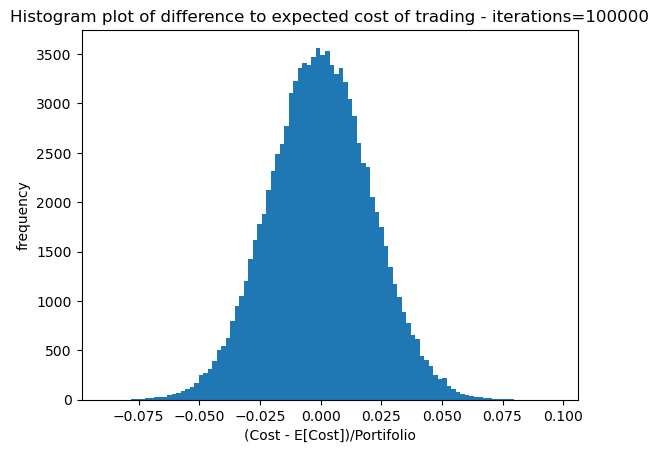

-0.00013980082882298776
0.020873653179281353


In [138]:
iterations = int(1e5)

percentage_difference = [(complete_simulation_equally(X,gamma,eps,eta,sigma,T,N) - expected_linear_trading_cost(X,gamma,eps,eta,T,N))/ (S0 * X) for _ in range(iterations)]

plt.hist(percentage_difference, bins = 100)
plt.title(f"Histogram plot of difference to expected cost of trading - {iterations=}")
plt.ylabel('frequency')
plt.xlabel('(Cost - E[Cost])/Portifolio')
plt.show()

print(np.mean(percentage_difference))
print(np.std(percentage_difference))

### Implementing functions

In [139]:
def compute_xs(
        X: float, 
        T: float, 
        t: float, 
        k: float
        ) -> np.array:
    '''
    Intermediary function for the optimal portifolio computation
    '''
    return X * np.sinh(k* (T - t)) / np.sinh(k*T)

def optimal_allocation(
        X: float, 
        gamma: float, 
        eps: float, 
        eta: float, 
        T: float, 
        N: int,
        lamb : float
        ) -> np.array:

    '''
    Computes the optimal portifolio size at each step
    '''
    
    portifolio_size = np.zeros(N)
    
    tau = T / N
    k = (lamb * sigma**2) / (1 - (gamma*tau)/(2*eta))

    ts = np.arange(1,N+1) * tau
    Vcompute_xs = np.vectorize(lambda x : compute_xs(X,T,x,k))

    portifolio_size = Vcompute_xs(ts)

    return portifolio_size

### Visualizing the portifolio

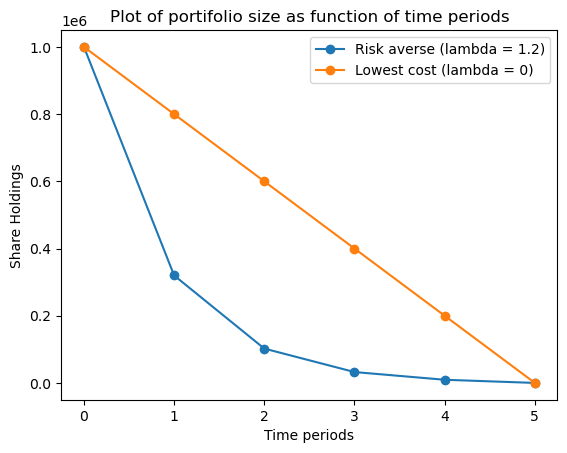

In [173]:
portifolio_size = np.ones(N+1) * X
portifolio_size_neutral = np.ones(N+1) * X

portifolio_size[1:] = optimal_allocation(X,gamma,eps,eta,T,N,1.2)
portifolio_size_neutral[1:] = optimal_allocation(X,gamma,eps,eta,T,N,0.01)

plt.plot(portifolio_size, linestyle = '-', marker = 'o')
plt.plot(portifolio_size_neutral, marker = 'o')
plt.title('Plot of portifolio size as function of time periods')
plt.legend(['Risk averse (lambda = 1.2)', 'Lowest cost (lambda = 0)'])
plt.xlabel('Time periods')
plt.ylabel('Share Holdings')
plt.show()